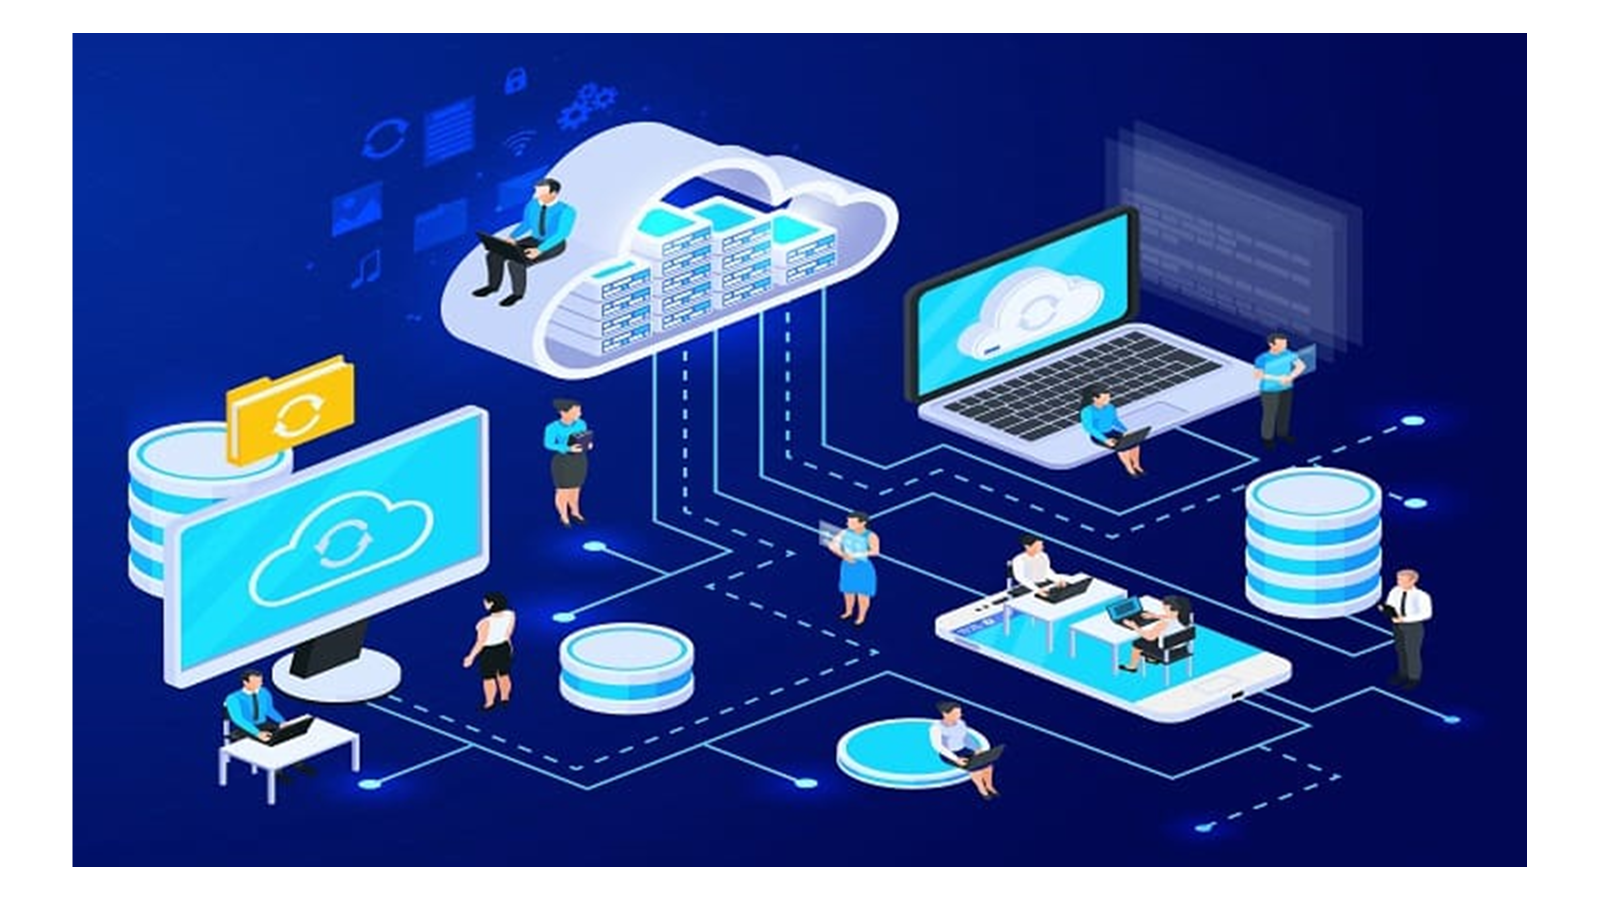

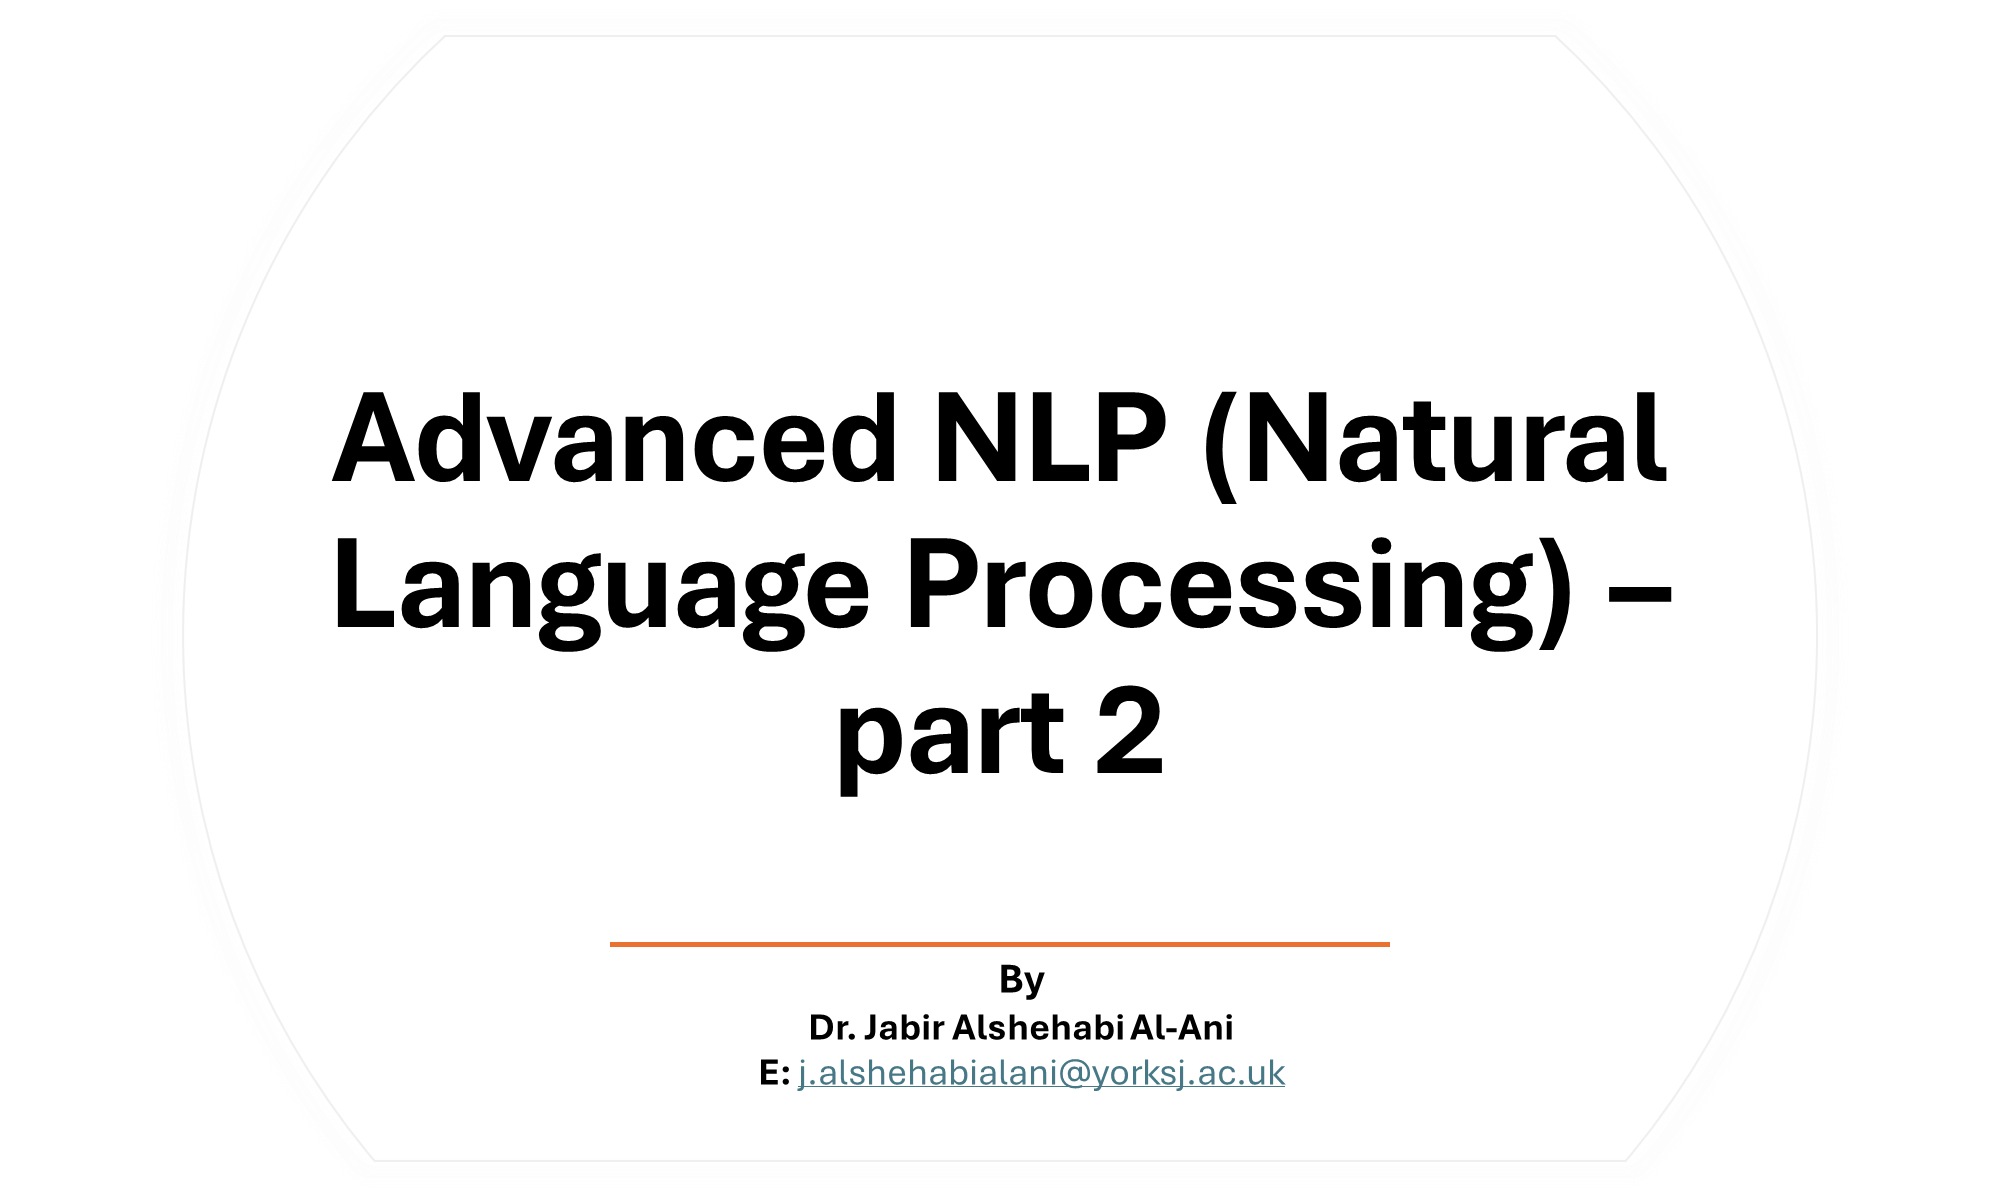

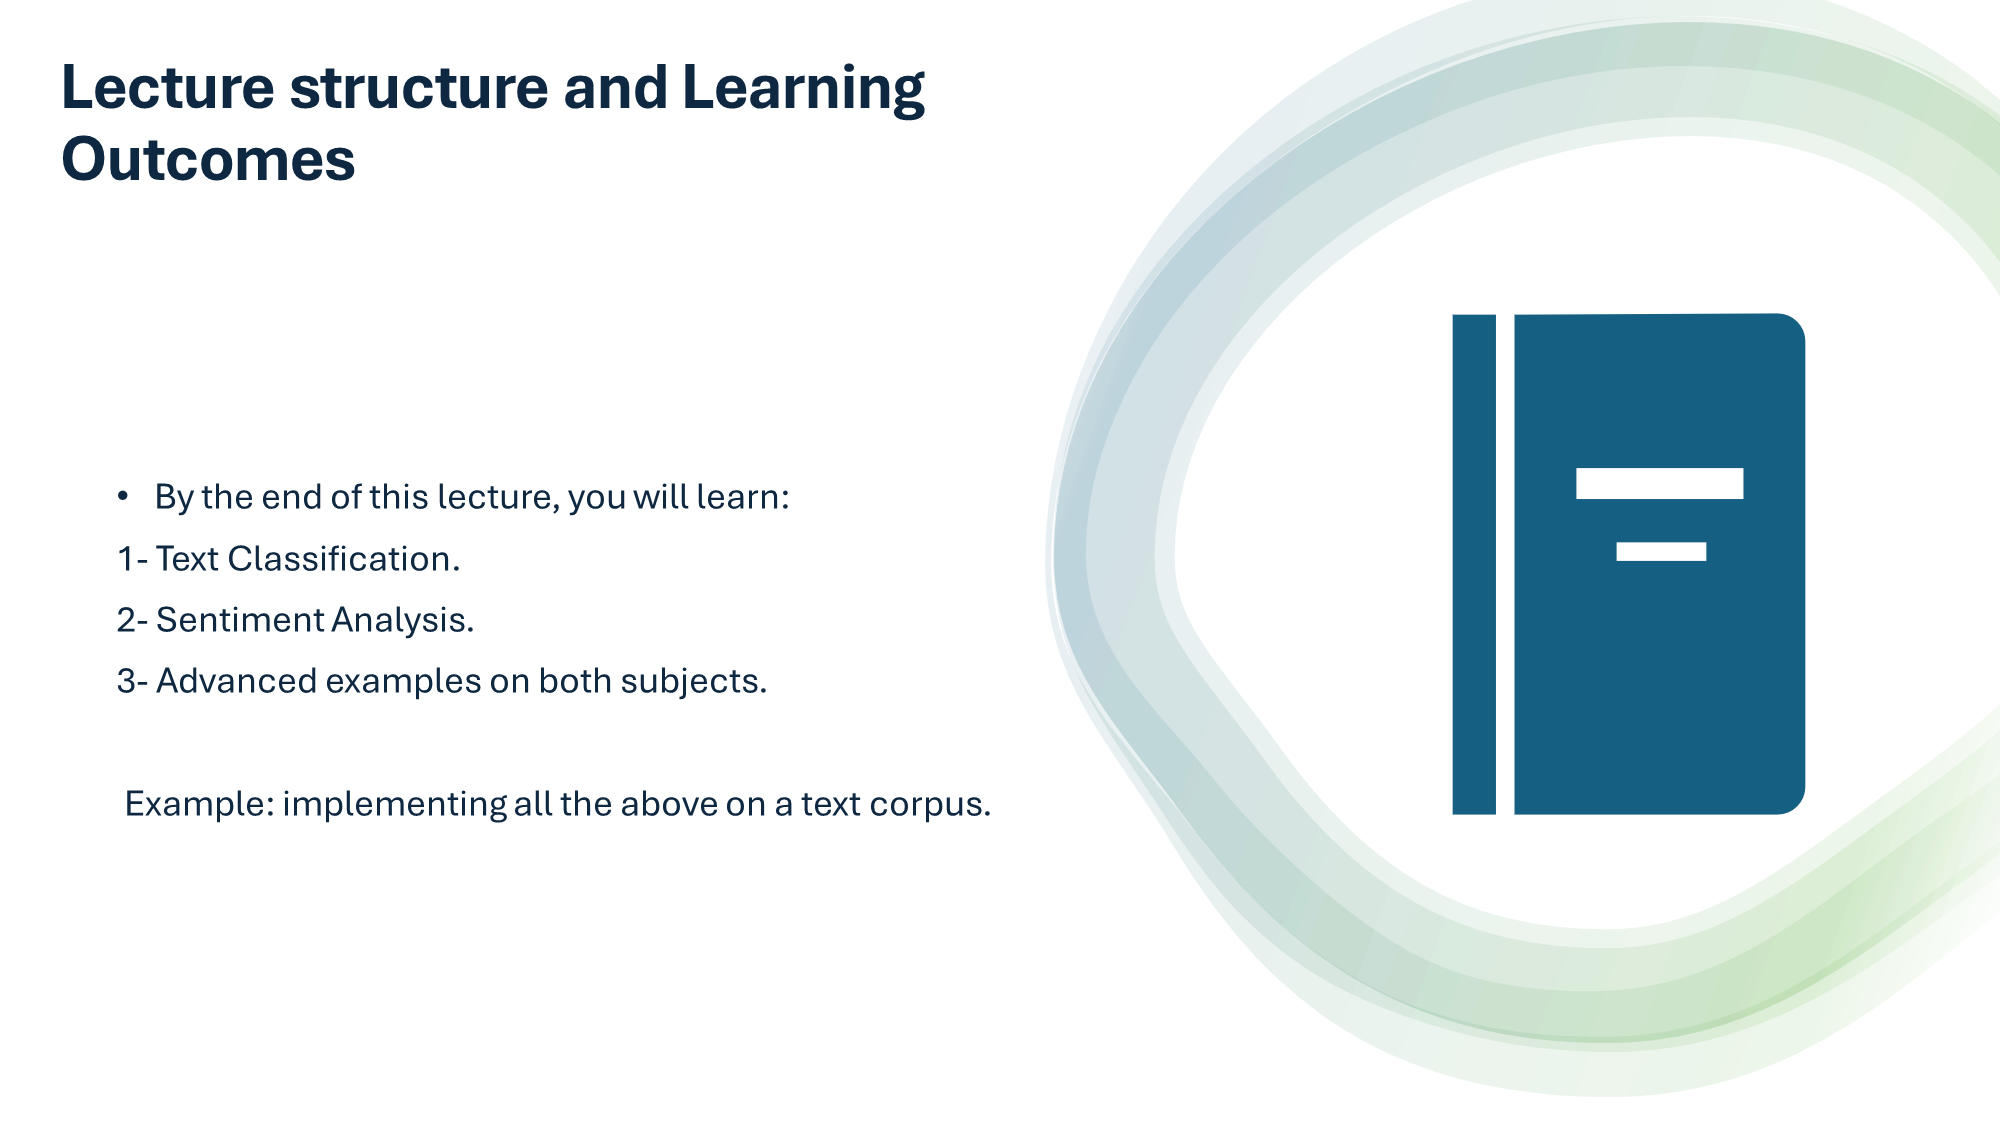

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
#ON_COLAB = 'google.colab' in sys.modules

#if ON_COLAB:
#    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
#    os.system(f'wget {GIT_ROOT}/ch06/setup.py')

#%run -i setup.py

## Load Python Settings<div class="tocSkip"/>


In [5]:
import sys
sys.executable

conda env create --name blueprints --file blueprints.yml
conda activate blueprints

SyntaxError: invalid syntax (209942795.py, line 4)

In [3]:
%run "settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# path to import blueprints packages \packages\blueprints
#sys.path.append('/packages')

In [4]:
print(sys.path)

['C:\\Users\\chees\\Degree Apprenticeship\\DSC6001M Advanced Data Applications\\Week 7 Resources-20240425', 'C:\\Users\\chees\\anaconda3\\python38.zip', 'C:\\Users\\chees\\anaconda3\\DLLs', 'C:\\Users\\chees\\anaconda3\\lib', 'C:\\Users\\chees\\anaconda3', '', 'C:\\Users\\chees\\anaconda3\\lib\\site-packages', 'C:\\Users\\chees\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\chees\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\chees\\anaconda3\\lib\\site-packages\\Pythonwin', '/packages', '/packages']


In [5]:
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from blueprints.preparation import clean

ModuleNotFoundError: No module named 'blueprints'

## What you'll learn and what we will build

# Introducing the Java Development Tools Bug Dataset

In [11]:
#BASE_DIR = C:/Users/chees/Degree Apprenticeship/DSC6001M Advanced Data Applications/Week 1 Resources-20240208/data.zip

file = "eclipse_jdt.csv"
file = f"/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
print (df.columns)
df[['Issue_id','Priority','Component','Title','Description']].sample(2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: '/jdt-bugs-dataset/eclipse_jdt.csv.gz'

In [23]:
df = df.drop(columns=['Duplicated_issue']) ###
pd.set_option('display.max_colwidth', -1)
df.sample(1, random_state=123).T

,11811
Issue_id,33113
Priority,P3
Component,Debug
Title,Evaluating for loop suspends in URLClassLoader
Description,Debug to a breakpoint in some HelloWorld program. In the DisplayView; highlight and ; Display the following code snippet:; ; for (int i = 0; i < 10; i++) {; System.out.println(i);; }; ; Instead of just reporting No explicit return value; the debugger suspends in the ; URLClassLoader; apparently trying to load the class int. You have hit Resume several ; more times before the evaluation completes. The DebugView does not indicate why it ; has stopped (the thread is just labelled Evaluating). This behavior does not happen if ; you turn of the Suspend on uncaught exceptions preference.
Status,VERIFIED
Resolution,FIXED
Version,2.1
Created_time,2003-02-25 15:40:00 -0500
Resolved_time,2003-03-05 17:11:17 -0500


<AxesSubplot:>

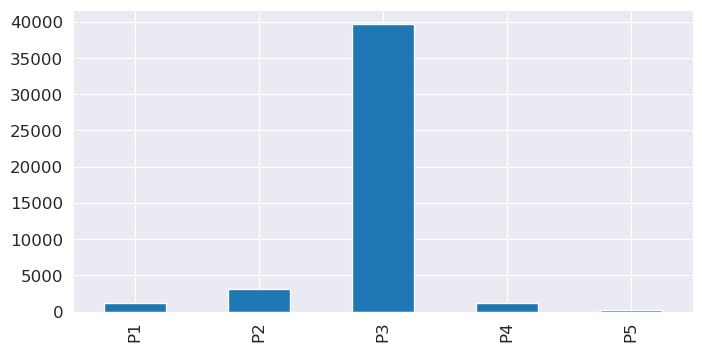

In [6]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [7]:
df['Component'].value_counts()

UI       17479
Core     13669
Debug    7542 
Text     5901 
APT      406  
Doc      299  
Name: Component, dtype: int64

# Blueprint: Building a Text Classification system

## Step 1 - Data Preparation

In [24]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [25]:
from blueprints.preparation import clean
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
42439,P3,Regression in TypeHierarchyPerfTest#testOpenObjectHierarchy() I20110329-0800; ; http://download.eclipse.org/eclipse/downloads/drops/I20110329-0800/performance/eplnx2/Scenario415.html; ; The regression can be seen on all platforms.; ; Also TypeHierarchyPerfTest#testOpenCollHierarchy() shows erratic behavior on all platforms.
30486,P3,introduce indirection: misleading warning about duplicate method 3.2 M5 testing; ; have two classes; Foo and Bar; Foo with method m; refactor introduce indirection on m; warning: duplicate method m in declaring class (ok); change declaring class to Bar; ; the warning is still there; despite that Bar does not contain any methods; expected: the warning goes away as the declaring class is changed


## Step 2 - Train-Test Split

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


## Step 3 - Training the machine learning model

In [18]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [19]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

## Step 4 - Model Evaluation

In [20]:
X_test_tf = tfidf.transform(X_test)

In [21]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


In [22]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=42, strategy='most_frequent')

Accuracy Score -  0.8769281988680502


### Precision and Recall


In [23]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

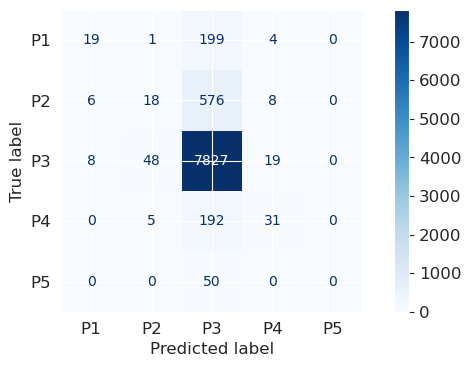

In [24]:
## Old code:

# plot_confusion_matrix(model1,X_test_tf,
#                       Y_test, values_format='d',
#                       cmap=plt.cm.Blues)
# plt.show()

## New code:

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [25]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



### Class Imbalance


In [26]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5    252 
Name: Priority, dtype: int64

# Final Blueprint for Text Classification

In [27]:
# Loading the balanced dataframe

df = df_balanced[['text', 'Priority']]
df = df.dropna()

# Step 1 - Data Preparation

df['text'] = df['text'].apply(clean)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

# Step 4 - Model Evaluation

X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Size of Training Data  7636
Size of Test Data  1909


LinearSVC(random_state=0, tol=1e-05)

Accuracy Score -  0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



In [28]:
clf = DummyClassifier(strategy='stratified', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

DummyClassifier(random_state=21, strategy='stratified')

Accuracy Score -  0.31691985332634887


In [29]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show old instance using build 20020917; ; Step to reproduce:; 1) create a selfhosting workspace (20020917).; 2) put a breakpoint in CompletionEngine at line 774 ; CompilationUnitDeclaration parsedUnit = parser.dietParse(...).; 3) create a launch configuration Runtime Workbench.; 4) launch this configuration in debugger.; 5) create a Java project.; 6) create a class.; 7) do ctrl+space in editor to hit breakpoint.; 8) look the id of the parser field of CompletionEngine in the variable view .; 9) step into parser.dietParse(...).; 10) in variable view the id of the parser is the same as step 8.; 11) do resume.; 12) do ctrl+space in editor to hit breakpoint.; 13) the id of the parser field is the same as step 8 (but it should not be the ; same instance of CompletionParser).; 14) step into parser.dietParse(...).; 15) the id of parser is a new id (as expected).; ; It seems that variable view doesnt show the right instance in the step 13.,P1,P1
34854,model proxy created for Java debug target in var view While investigating bug 177910; I found that the deltas for thread creation were duplicated in the output produced by Walter. I discovered that two model proxies are created for Java debug targets because the JavaModelProxyFactory does not limit the creation of proxies for targets to the debug view (as it should).,P2,P2


In [30]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=33)

,text,actual,predicted
40065,Too many semicolons after constructor completion I20090611-1540; ; public class Try {; Object m() {; return null;; }; }; ; select null; type new Runna; Ctrl+Space; press Enter to select the anonymous proposal for Runnable(); ; => Result:; ; public class Try {; Object m() {; return new Runnable() {; ; public void run() {; // TODO Auto-generated method stub; ; }; };;;; };,P2,P3
7178,Next/Previous buttons have double image 20020606 XP; ; 1) Open Java editor; Outline; Search view; 2) Click in editor; click in outline; click in search; 3) Note that the show previous/ show next buttons have a double image.; Hover over the button and the imgae is corrected,P2,P3


# Cross-Validation

In [ ]:
# Vectorization

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

# Cross Validation with 5 folds

scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)

print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

# Hyperparameter Tuning with Grid Search

In [ ]:
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(
        stop_words="english")), ('model',
                                 LinearSVC(random_state=21, tol=1e-5))])

grid_param = [{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__penalty': ['l2'],
    'model__loss': ['hinge'],
    'model__max_iter': [10000]
}, {
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1, 6)],
    'model__C': [1, 10],
    'model__tol': [1e-2, 1e-3]
}]

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

In [ ]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

# Blueprint recap and conclusion


In [ ]:
# Flag that determines the choice of SVC (True) and LinearSVC (False)
runSVC = True

# Loading the dataframe

file = "eclipse_jdt.csv"
file = f"{BASE_DIR}/data/jdt-bugs-dataset/eclipse_jdt.csv.gz" ### real location
df = pd.read_csv(file)
df = df[['Title', 'Description', 'Component']]
df = df.dropna()
df['text'] = df['Title'] + df['Description']
df = df.drop(columns=['Title', 'Description'])

# Step 1 - Data Preparation
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]

if (runSVC):
    # Sample the data when running SVC to ensure reasonable run-times
    df = df.groupby('Component', as_index=False).apply(pd.DataFrame.sample,
                                                       random_state=42,
                                                       frac=.2)

# Step 2 - Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Component'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Component'])
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

# Step 3 - Training the Machine Learning model
tfidf = TfidfVectorizer(stop_words="english")

if (runSVC):
    model = SVC(random_state=42, probability=True)
    grid_param = [{
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__kernel': ['linear']
    }]
else:
    model = LinearSVC(random_state=42, tol=1e-5)
    grid_param = {
        'tfidf__min_df': [5, 10],
        'tfidf__ngram_range': [(1, 3), (1, 6)],
        'model__C': [1, 100],
        'model__loss': ['hinge']
    }

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=5)

gridSearchProcessor.fit(X_train, Y_train)

best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

# Step 4 - Model Evaluation

Y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

In [ ]:
clf = DummyClassifier(strategy='most_frequent', random_state=21)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

In [ ]:
## Create a dataframe combining the Title and Description, 
## Actual and Predicted values that we can explore
frame = { 'text': X_test, 'actual': Y_test, 'predicted': Y_pred } 
result = pd.DataFrame(frame)

result[result['actual'] == result['predicted']].sample(2, random_state=21)

In [ ]:
result[result['actual'] != result['predicted']].sample(2, random_state=42)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [2]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master'
    os.system(f'wget {GIT_ROOT}/ch11/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [3]:
# path to import blueprints packages
sys.path.append(BASE_DIR + '/packages')

import pandas as pd
from sklearn import preprocessing
import nltk
nltk.download('opinion_lexicon')

C:\Users\jatna\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\jatna\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

# Sentiment Analysis

# Introducing the Amazon Customer Reviews Dataset

In [4]:
file = "reviews_5_balanced.json.gz"
file = f"{BASE_DIR}/data/amazon-product-reviews/reviews_5_balanced.json.gz" ### real location
df = pd.read_json(file, lines=True)
df = df.drop(columns=['reviewTime','unixReviewTime']) ###
df = df.rename(columns={'reviewText': 'text'}) ###
df.sample(5, random_state=12)

,overall,verified,reviewerID,asin,text,summary
163807,5,False,A2A8GHFXUG1B28,B0045Z4JAI,Good Decaf... it has a good flavour for a deca...,Nice!
195640,5,True,A1VU337W6PKAR3,B00K0TIC56,I could not ask for a better system for my sma...,I could not ask for a better system for my sma...
167820,4,True,A1Z5TT1BBSDLRM,B0012ORBT6,good product at a good price and saves a trip ...,Four Stars
104268,1,False,A4PRXX2G8900X,B005SPI45U,I like the principle of a raw chip - something...,No better alternatives but still tastes bad.
51961,1,True,AYETYLNYDIS2S,B00D1HLUP8,"Fake China knockoff, you get what you pay for.",Definitely not OEM


# Blueprint: Sentiment Analysis using Lexicon based approaches

## Bing Liu Lexicon

In [5]:
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words in opinion lexicon',
      opinion_lexicon.positive()[:5])
print('Examples of negative words in opinion lexicon',
      opinion_lexicon.negative()[:5])

Total number of words in opinion lexicon 6789
Examples of positive words in opinion lexicon ['a+', 'abound', 'abounds', 'abundance', 'abundant']
Examples of negative words in opinion lexicon ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']


In [6]:
# Let's create a dictionary which we can use for scoring our review text
# Please uncomment this line the first-time you run this code to download the vocabulary from nltk ###
# nltk.download('punkt') ###
df.rename(columns={"reviewText": "text"}, inplace=True)
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
        word_dict[word] = pos_score
        
# Adding the negative words to the dictionary
for word in opinion_lexicon.negative():
        word_dict[word] = neg_score
        
def bing_liu_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return sentiment_score / len(bag_of_words)

In [7]:
df['Bing_Liu_Score'] = df['text'].apply(bing_liu_score)
df[['asin','text','Bing_Liu_Score']].sample(2, random_state=0)

,asin,text,Bing_Liu_Score
188097,B00099QWOU,As expected,0.00
184654,B000RW1XO8,Works as designed...,0.25


In [8]:
df['Bing_Liu_Score'] = preprocessing.scale(df['Bing_Liu_Score'])
df.groupby('overall').agg({'Bing_Liu_Score':'mean'})

,Bing_Liu_Score
overall,
1,-0.587784
2,-0.427183
4,0.345291
5,0.529736


# Supervised Learning Approaches

## Preparing data for a supervised learning approach

In [9]:
pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

file = "reviews_5_balanced.json.gz"
file = f"{BASE_DIR}/data/amazon-product-reviews/reviews_5_balanced.json.gz" ### real location
df = pd.read_json(file, lines=True)
df = df.rename(columns={'reviewText': 'text'})  ###

# Assigning a new [1,0] target class label based on the product rating
df['sentiment'] = 0
df.loc[df['overall'] > 3, 'sentiment'] = 1
df.loc[df['overall'] < 3, 'sentiment'] = 0

# Removing unecessary columns to keep a simple dataframe 
df.drop(columns=[
    'reviewTime', 'unixReviewTime', 'overall', 'reviewerID', 'summary'],
        inplace=True)
df.sample(3)

,verified,asin,text,sentiment
244211,True,B003YKP1Y8,tast good,1
58083,True,B00JQWL6K6,No signal once case is on phone,0
68231,True,B00V9PTXYE,Ordered wrong item,0


# Blueprint: Vectorizing text data and applying a supervised machine learning algorithm

## Step 1 - Data Preparation

In [10]:
#from blueprints import clean
df['text_orig'] = df['text'].copy()
#df['text'] = df['text'].apply(clean)

In [10]:
# First method that performs Tokenization and Lemmatization by re-using the blueprint from Chapter 4 
# This can take longer to run due to the size of the dataset!
import textacy
import spacy
from spacy.lang.en import STOP_WORDS as stop_words
nlp = spacy.load('en')

def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc,
                                                    filter_stops = False,
                                                    filter_punct = True,
                                                    filter_nums = True,
                                                    include_pos = ['ADJ', 'NOUN', 'VERB', 'ADV'],
                                                    exclude_pos = None,
                                                    min_freq = 1)]

def clean_text(text):
    doc = nlp(text)
    lemmas = extract_lemmas(doc)
    return ' '.join(lemmas)

In [11]:
# Alternate method that uses Wordnet POS tags instead of spaCy - can run faster with similar accuracy
# Tokenization and Lemmatization using wordnet. Re-uses parts of blueprint from Chapter 4
# Uses wordnet POS tags instead of spaCy
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [12]:
df["text"] = df["text"].apply(clean_text)

## Remove observations that are empty after the cleaning step
df = df[df['text'].str.len() != 0]

## Step 2 - Train-Test Split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['sentiment'])

print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(Y_train == 1)/ len(Y_train) * 100.0))
print ('Negative Sentiment ', str(sum(Y_train == 0)/ len(Y_train) * 100.0))

print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(Y_test == 1)/ len(Y_test) * 100.0))
print ('Negative Sentiment ', str(sum(Y_test == 0)/ len(Y_test) * 100.0))

Size of Training Data  234108
Size of Test Data  58527
Distribution of classes in Training Data :
Positive Sentiment  50.90770071932612
Negative Sentiment  49.09229928067388
Distribution of classes in Testing Data :
Positive Sentiment  50.9081278726058
Negative Sentiment  49.09187212739419


## Step 3 - Text Vectorization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,1))
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

## Step 4 - Training the Machine Learning model

In [15]:
from sklearn.svm import LinearSVC

model1 = LinearSVC(random_state=42, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=42, tol=1e-05)

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print ('ROC-AUC Score - ', roc_auc_score(Y_test, Y_pred))

Accuracy Score -  0.8658396979172006
ROC-AUC Score -  0.8660667427476778


In [17]:
sample_reviews = df.sample(5, random_state=22)
sample_reviews_tf = tfidf.transform(sample_reviews['text'])
sentiment_predictions = model1.predict(sample_reviews_tf)
sentiment_predictions = pd.DataFrame(data = sentiment_predictions,
                                     index=sample_reviews.index,
                                     columns=['sentiment_prediction'])
sample_reviews = pd.concat([sample_reviews, sentiment_predictions], axis=1)
print ('Some sample reviews with their sentiment - ')
sample_reviews[['text_orig','sentiment_prediction']]

Some sample reviews with their sentiment - 


,text_orig,sentiment_prediction
29500,"Its a nice night light, but not much else apparently!",1
98387,"Way to small, do not know what to do with them or how to use them",0
113648,"Didn't make the room ""blue"" enough - returned with no questions asked",0
281527,Excellent,1
233713,fit like oem and looks good,1


In [18]:
def baseline_scorer(text):
    score = bing_liu_score(text)
    if score > 0:
        return 1
    else:
        return 0
    
Y_pred_baseline = X_test.apply(baseline_scorer)
acc_score = accuracy_score(Y_pred_baseline, Y_test)
print (acc_score)

0.7521998393903668


### Saving the trained model and vectorizer for use with the API later

In [36]:
import pickle

pickle.dump(model1, open('models/sentiment_classification.pickle','wb'))
pickle.dump(tfidf, open('models/sentiment_vectorizer.pickle','wb'))

Group work:
How to implement Sentiment Analysis using a different dataset
Is there any unsupervised technique or algorithm to be used

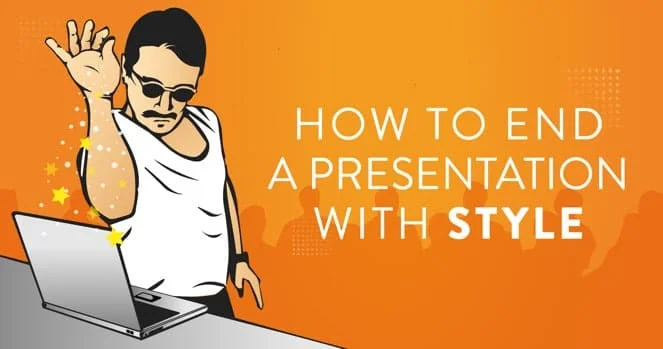